In [1]:
import faiss
import json
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b0
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

from utils.custom_dataset import FabulaDataset
from utils.get_embedding import prepare_data_features

In [2]:
device = 'cuda'
colors = {0: '#ff1110', 1: '#4287f5', 2: '#025202', 3: '#00ffff', 4: '#8000ff',
          5: '#00ff95', 6: '#d900ff', 7: '#48ff00', 8: '#ff0095', 9: '#d5deba',
          10: '#f0b6ec'}

image_shape = 256
df = pd.read_csv(f'../data/dataset.csv')
df

,full_image_path,image_name,label,part
0,../data/dataset/bags/item-ecdddda8-3bae-4deb-a...,item-ecdddda8-3bae-4deb-a172-84d0a5318067.jpg,bags,train
1,../data/dataset/bags/item-d66069af-dde2-4f69-b...,item-d66069af-dde2-4f69-b213-d32369341997.jpeg,bags,train
2,../data/dataset/bags/item-8ed28ab8-eef8-4f03-8...,item-8ed28ab8-eef8-4f03-8639-f90cfb3fecfc.jpg,bags,train
3,../data/dataset/bags/item-eda94df8-b0e0-4180-b...,item-eda94df8-b0e0-4180-bac9-d1d9b26fbcb7 (1).jpg,bags,train
4,../data/dataset/bags/item-723a5fa9-dd97-411c-8...,item-723a5fa9-dd97-411c-89c4-714f82ed8997.jpg,bags,train
...,...,...,...,...
288,../data/dataset/upper_body/item-8a38fe1b-2952-...,item-8a38fe1b-2952-46a4-a480-a48843e44c29.jpg,upper_body,test
289,../data/dataset/upper_body/item-1660540d-c5bd-...,item-1660540d-c5bd-4fd0-a19d-b0127a092212.jpg,upper_body,test
290,../data/dataset/upper_body/item-50aa78a9-5bc7-...,item-50aa78a9-5bc7-4363-ad45-09a0aed1b2bb.jpg,upper_body,test
291,../data/dataset/upper_body/item-ff9f5ae2-77ec-...,item-ff9f5ae2-77ec-4140-9d09-5f934f2a20d1.jpg,upper_body,test


In [3]:
train_dataset = FabulaDataset(df=df[df['part'] == 'train'],
                              transform=transforms.Compose([
                                  transforms.Resize((image_shape, image_shape)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                              ]))

test_dataset = FabulaDataset(df=df[df['part'] == 'test'],
                              transform=transforms.Compose([
                                  transforms.Resize((image_shape, image_shape)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                              ]))

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

model = efficientnet_b0(pretrained=True)
model.classifier = torch.nn.Identity()

train_embeddings, train_labels = prepare_data_features(model, train_dataloader, device)
test_embeddings, test_labels = prepare_data_features(model, test_dataloader, device)
print(train_embeddings.shape, train_labels.shape, df[df['part'] == 'train'].shape, df[df['part'] == 'test'].shape, '\n')

train_embeddings = train_embeddings.numpy()
train_labels = train_labels.numpy()

test_embeddings = test_embeddings.numpy()
test_labels = test_labels.numpy()

/mnt/ntr_work/project/fabula/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/ntr_work/project/fabula/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 4/4 [00:00<00:00,  5.15it/s]

torch.Size([232, 1280]) torch.Size([232]) (232, 4) (61, 4) 



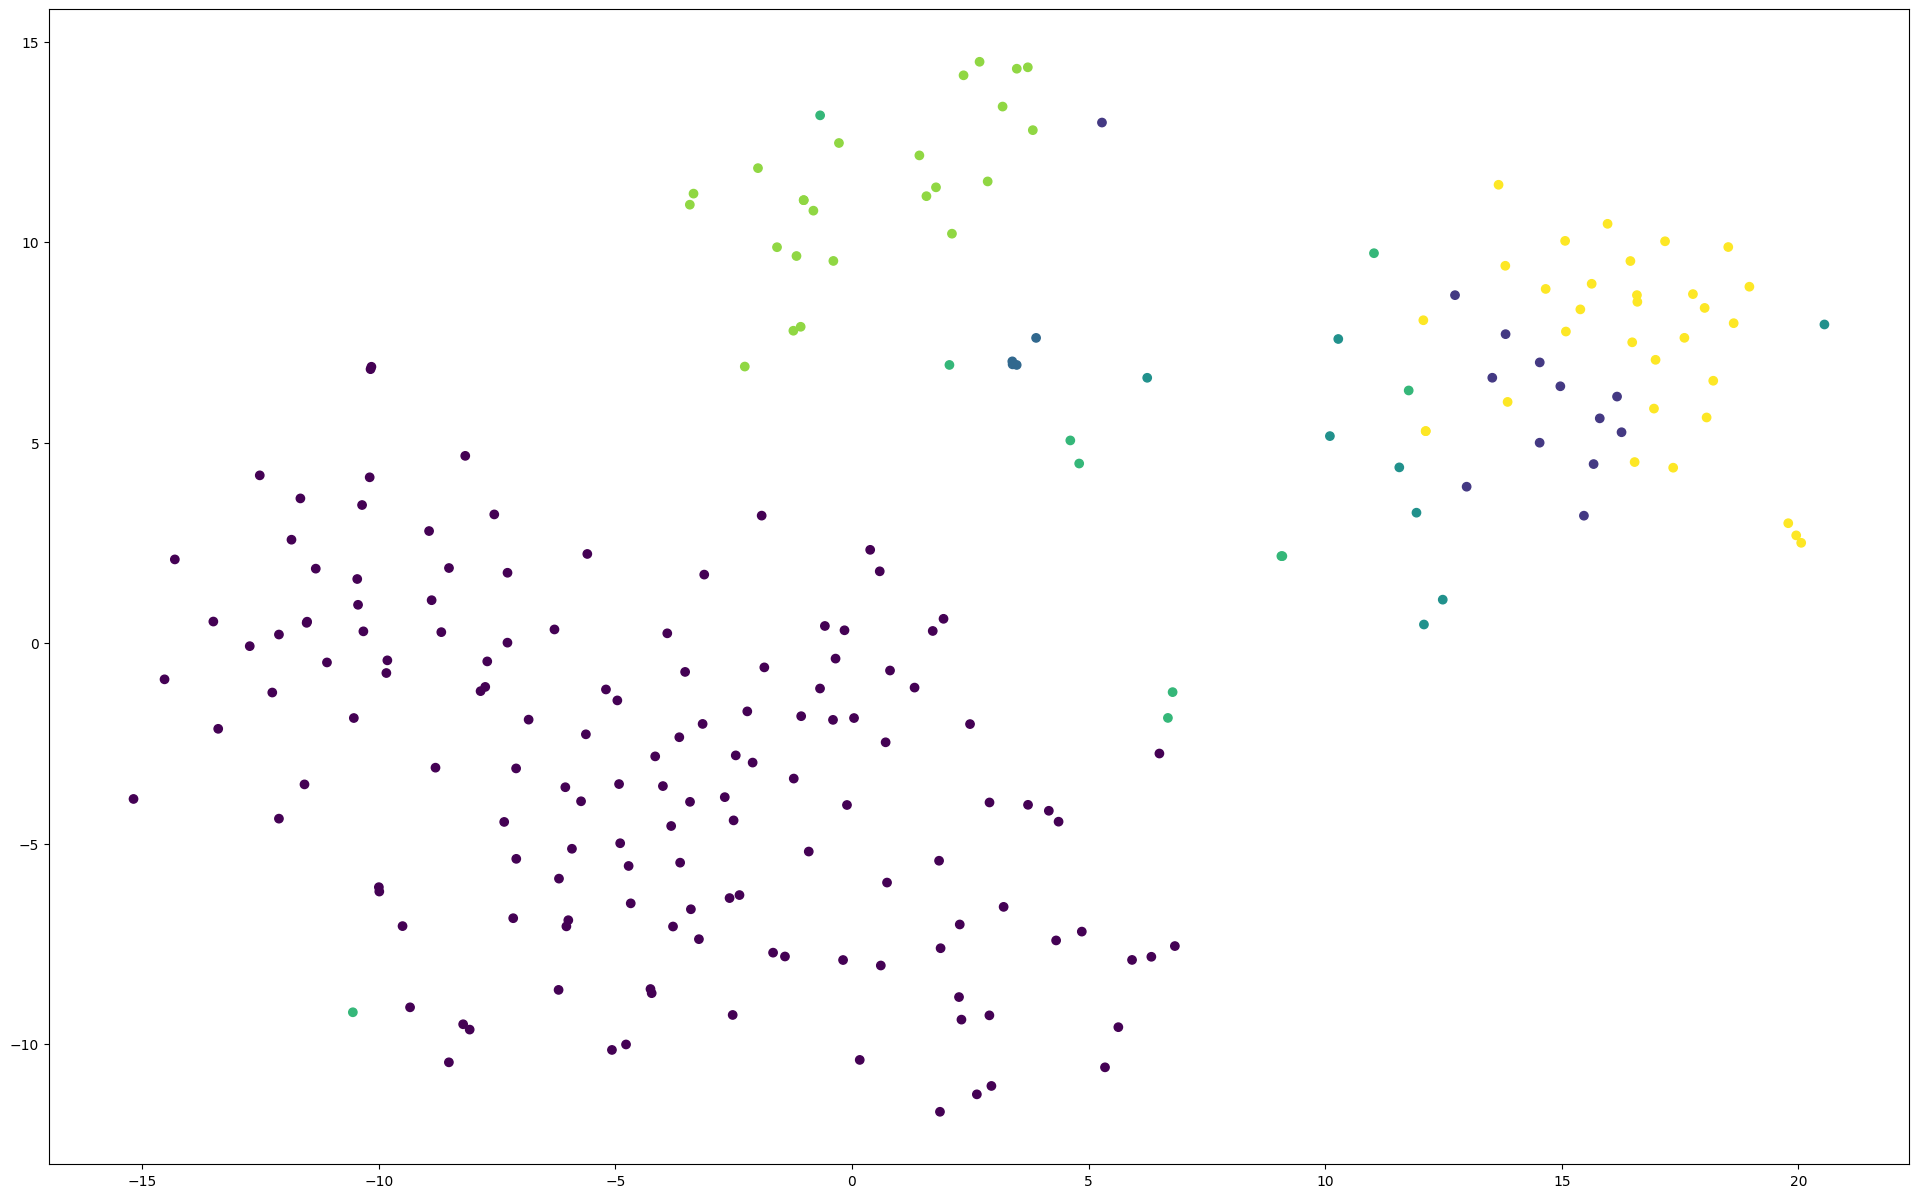

In [4]:
t_sne = TSNE(n_components=2)
reduced_features = t_sne.fit_transform(train_embeddings)

plt.figure(figsize=(24, 15))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=train_labels, cmap='viridis')
plt.show()

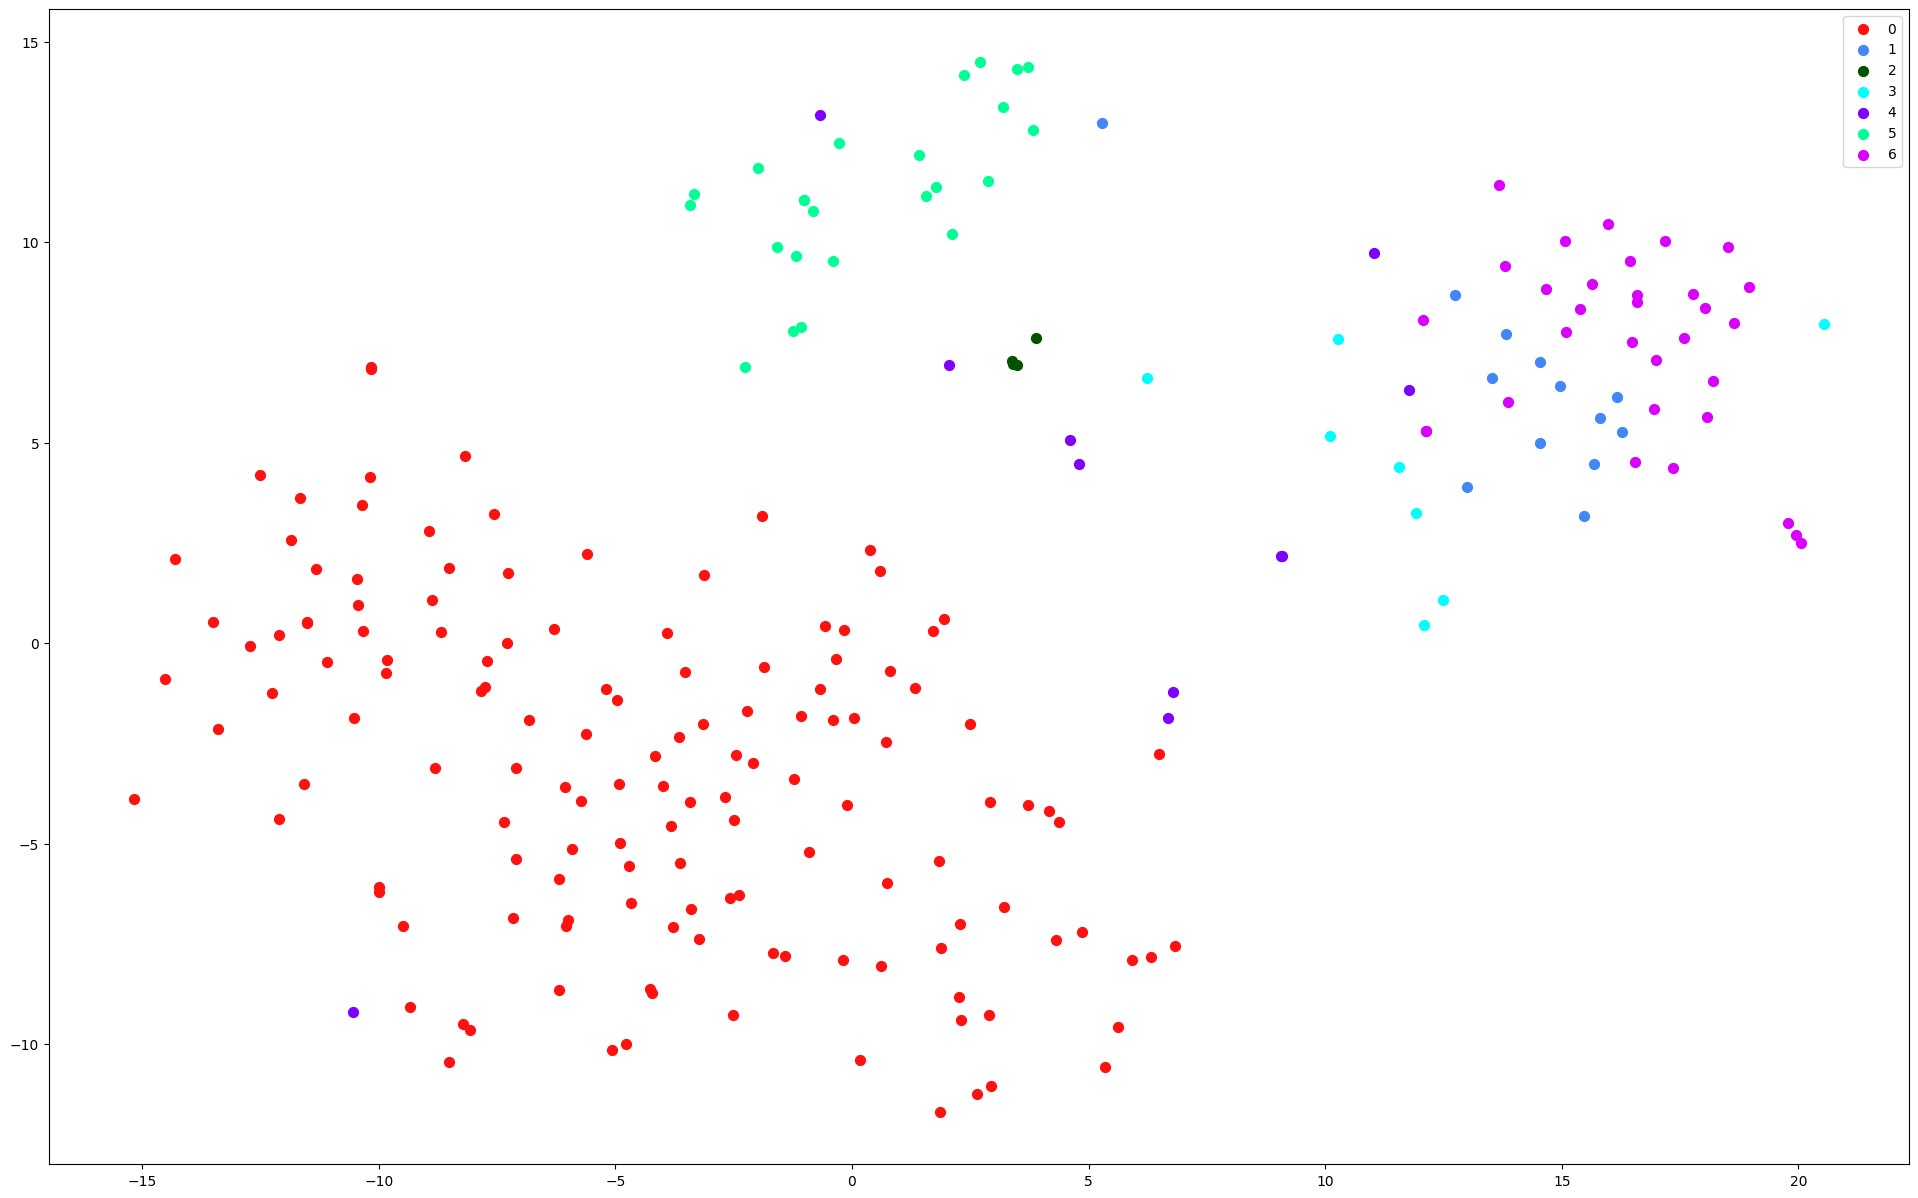

In [5]:
fig, ax = plt.subplots(figsize=(24, 15))

for ind, g in enumerate(set(train_labels)):
    zxc2 = reduced_features[train_labels == g]
    ax.scatter(zxc2[:, 0], zxc2[:, 1], c=colors[g], label=g, alpha=1.0, marker='o', s=50)

ax.legend()
plt.show()

# KNN


In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

for k in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    knn_clf = KNeighborsClassifier(n_neighbors=k, p=1)
    
    knn_clf.fit(train_embeddings, train_labels)
    predict_ = knn_clf.predict(test_embeddings)
    
    print(f'k: {k} micro: {round(f1_score(test_labels, predict_, average="micro") * 100, 2)} macro: {round(f1_score(test_labels, predict_, average="macro") *100, 2)}')

k: 1 micro: 90.16 macro: 75.92
k: 2 micro: 90.16 macro: 68.97
k: 3 micro: 86.89 macro: 59.26
k: 4 micro: 81.97 macro: 44.28
k: 5 micro: 83.61 macro: 48.1
k: 6 micro: 85.25 macro: 53.55
k: 7 micro: 85.25 macro: 55.24
k: 8 micro: 85.25 macro: 55.24
k: 9 micro: 83.61 macro: 47.65
k: 10 micro: 85.25 macro: 55.24


# faiss

In [7]:
dim = train_embeddings.shape[1]
index = faiss.IndexFlatL2(dim)
# faiss.normalize_L2(train_embeddings)
print(index.is_trained)        

index.add(train_embeddings)
print(index.ntotal)           
# faiss.normalize_L2(test_embeddings)

for i in range(1, 11, 1):
    pred = []
    for vec in test_embeddings:
        vec = vec[None, :]
        D, I = index.search(vec, i)
        predicts = train_labels[I]

        vals, counts = np.unique(predicts, return_counts=True)
        pred.append(vals[np.argmax(counts)])
        
    print(f'{i} micro: {round(f1_score(test_labels, pred, average="micro") * 100, 2)} macro: {round(f1_score(test_labels, pred, average="macro") *100, 2)}')

True
232
1 micro: 88.52 macro: 70.75
2 micro: 90.16 macro: 79.95
3 micro: 86.89 macro: 61.45
4 micro: 85.25 macro: 53.48
5 micro: 85.25 macro: 58.46
6 micro: 86.89 macro: 62.46
7 micro: 88.52 macro: 65.05
8 micro: 88.52 macro: 65.05
9 micro: 86.89 macro: 65.62
10 micro: 85.25 macro: 57.8
